In [1]:
from Annotation_helper import *
import numpy as np
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import missingno as msno

In [3]:
import seaborn as sns
sns.set()

SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
data_folder = "../../Data"
structured_data_folder = data_folder + "/structured_data"
text_path = data_folder + "/text"
data_path = structured_data_folder + "/test.csv"
dist_folder = structured_data_folder + "/Distances"
figure_folder = "../Figures/Results/Embeddings"
model_folder = "../Models/Embeddings"
matches = pd.read_csv(structured_data_folder + "/Matches/Bas3.csv", index_col=0)
figure_folder = "../Figures/EDA/"

In [5]:
transactions = load_transactions("../../Data/structured_data\VOC Cochin Slave Transactions 1706-1801 - IISH - Database - 2018 - v1.csv")
permissions = load_permissions("../../Data/structured_data\VOC Cochin Slave Transport Permissions 1770-1795 - IISH - Database - 2018 - v1.csv")

E:\UvA\Scriptie\Thesis_code\Annotation\Annotation_helper.py:31: FutureWarning: The default value of regex will change from True to False in a future version.
  col = col.str.replace('[^a-zA-Z ]', '')


In [6]:
transactions

,Unnamed: 0,ID,Datum,VerkoperVoornaam,VerkoperPatroniem,VerkoperTussen,VerkoperAchternaam,VerkoperGender,VerkoperHerkomst,VerkoperBeroep,...,KoperEtniciteit,KoperStatus,SlaafNaamNieuw,SlaafNaamOrigineel,SlaafTaalNaam,SlaafKaste,SlaafGender,SlaafLeeftijd,Opmerking,Entry-ID
0,0,,,michiel,NaN,NaN,kruijs,m,NaN,metselaar,...,NaN,voc,december,NaN,NaN,NaN,m,NaN,NaN,0
1,1,,,michiel,NaN,NaN,kruijs,m,NaN,metselaar,...,NaN,voc,neptunes,NaN,NaN,NaN,m,NaN,NaN,1
2,2,,,gillis,NaN,van der,sloot,m,NaN,assistent,...,NaN,voc,dalima,NaN,NaN,NaN,v,NaN,NaN,2
3,3,,,michiel,NaN,NaN,kruys,m,NaN,metselaar,...,NaN,voc,februarij,NaN,NaN,NaN,m,NaN,NaN,3
4,4,,,jacob,NaN,NaN,smit,m,NaN,sergeant,...,NaN,voc,fortuyn,NaN,NaN,NaN,m,NaN,datum deels onleesbaar waarschijnlijk verkope...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,7192,,,schoesen,NaN,NaN,mira,o,NaN,NaN,...,moor,woonagtig te kalwettij,tanjon,kadia,NaN,moor,v,,NaN,7192
7193,7193,,,marielwittil schoe,NaN,NaN,miran,o,NaN,NaN,...,moor,woonagtig te kalwettij,ambar,koroenba,mallabaars,parea heiden,m,,NaN,7193
7194,7194,,,seidoe,NaN,NaN,japhar,m,NaN,NaN,...,moor,woonagtig te kalwettij,august,tjatten,mallabaars,poelia heiden,m,,NaN,7194
7195,7195,,,madatilparambil tjangaren,NaN,NaN,koma,o,NaN,NaN,...,moor,woonagtig te kalwettij,september,ramen,mallabaars,bettua heiden,m,,NaN,7195


In [7]:
transactions["Verkopernaam"] = transactions["VerkoperVoornaam"].fillna("") + " " + transactions["VerkoperTussen"].fillna("") + " " + transactions["VerkoperAchternaam"].fillna("")
transactions["Kopernaam"] = transactions["KoperVoornaam"].fillna("") + " " + transactions["KoperTussen"].fillna("") + " " + transactions["KoperAchternaam"].fillna("")
permissions["Bezitternaam"] = permissions["BezitterVoornaam"].fillna("") + " " + permissions["BezitterTussen"].fillna("") + " " + permissions["BezitterAchternaam"].fillna("")

In [8]:
print("Number of unique sellers: ", len(transactions["Verkopernaam"].unique()))
print("Number of unique buyers: ", len(transactions["Kopernaam"].unique()))
print("Number of unique owners: ", len(permissions["Bezitternaam"].unique()))

Number of unique sellers:  4648
Number of unique buyers:  3297
Number of unique owners:  1224


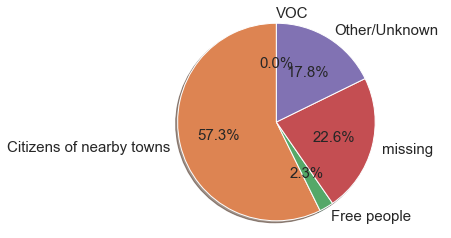

In [9]:
n_total = transactions.shape[0]
n_voc_sellers = (transactions["VerkoperStatus"] == "VOC").sum()
n_inw_sellers = transactions["VerkoperStatus"].str.contains('inw', case=False, regex=True).sum()
n_free_sellers = transactions["VerkoperStatus"].str.contains('vrij', case=False, regex=True).sum()
n_missing_buyers = transactions["KoperStatus"].isna().sum()


labels = 'VOC', 'Citizens of nearby towns', 'Free people', 'missing', 'Other/Unknown'
sizes = [n_voc_sellers, n_inw_sellers, n_free_sellers, n_missing_buyers]
sizes.append(n_total - sum(sizes))

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(figure_folder + 'seller_status.png', bbox_inches='tight')

[0, 367, 935, 1626, 4260]


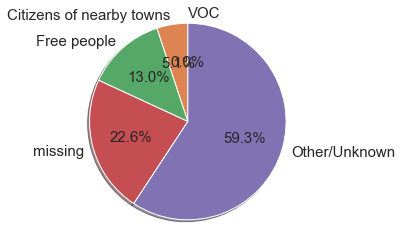

In [10]:
n_total = transactions.shape[0]
n_voc_sellers = (transactions["KoperStatus"] == "VOC").sum()
n_inw_sellers = transactions["KoperStatus"].str.contains('inw', case=False, regex=True).sum()
n_free_sellers = transactions["KoperStatus"].str.contains('vrij', case=False, regex=True).sum()
n_missing_buyers = transactions["KoperStatus"].isna().sum()


labels = 'VOC', 'Citizens of nearby towns', 'Free people', 'missing', 'Other/Unknown'
sizes = [n_voc_sellers, n_inw_sellers, n_free_sellers, n_missing_buyers]
sizes.append(n_total - sum(sizes))
print(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(figure_folder + 'buyer_status.png', bbox_inches='tight')

In [11]:
transactions["KoperStatus"].isna().sum()

1626

[0, 10, 167, 2991, 670]


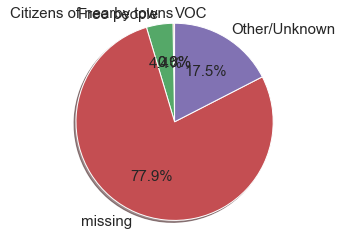

In [12]:
n_total = permissions.shape[0]
n_voc_sellers = (permissions["BezitterStatus"] == "VOC").sum()
n_inw_sellers = permissions["BezitterStatus"].str.contains('inw', case=False, regex=True).sum()
n_free_sellers = permissions["BezitterStatus"].str.contains('vrij', case=False, regex=True).sum()
n_missing_buyers = permissions["BezitterStatus"].isna().sum()


labels = 'VOC', 'Citizens of nearby towns', 'Free people', 'missing', 'Other/Unknown'
sizes = [n_voc_sellers, n_inw_sellers, n_free_sellers, n_missing_buyers]
sizes.append(n_total - sum(sizes))
print(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(figure_folder + 'owner_status.png', bbox_inches='tight')

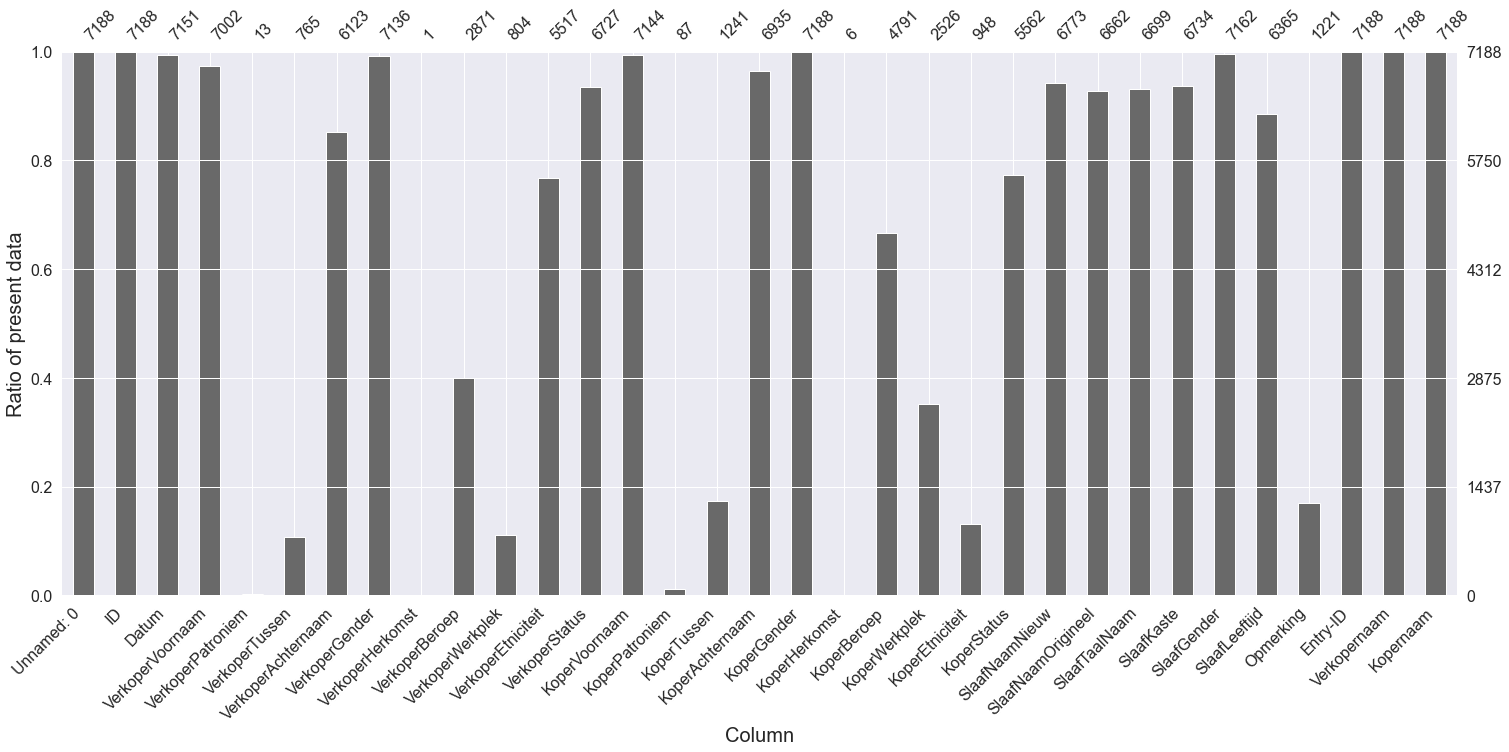

In [13]:
fontsize = 20
ax = msno.bar(transactions)
ax.set_xlabel('Column', fontsize=fontsize)
ax.set_ylabel('Ratio of present data', fontsize=fontsize)

plt.savefig(figure_folder + 'missing_transaction.png', bbox_inches='tight')

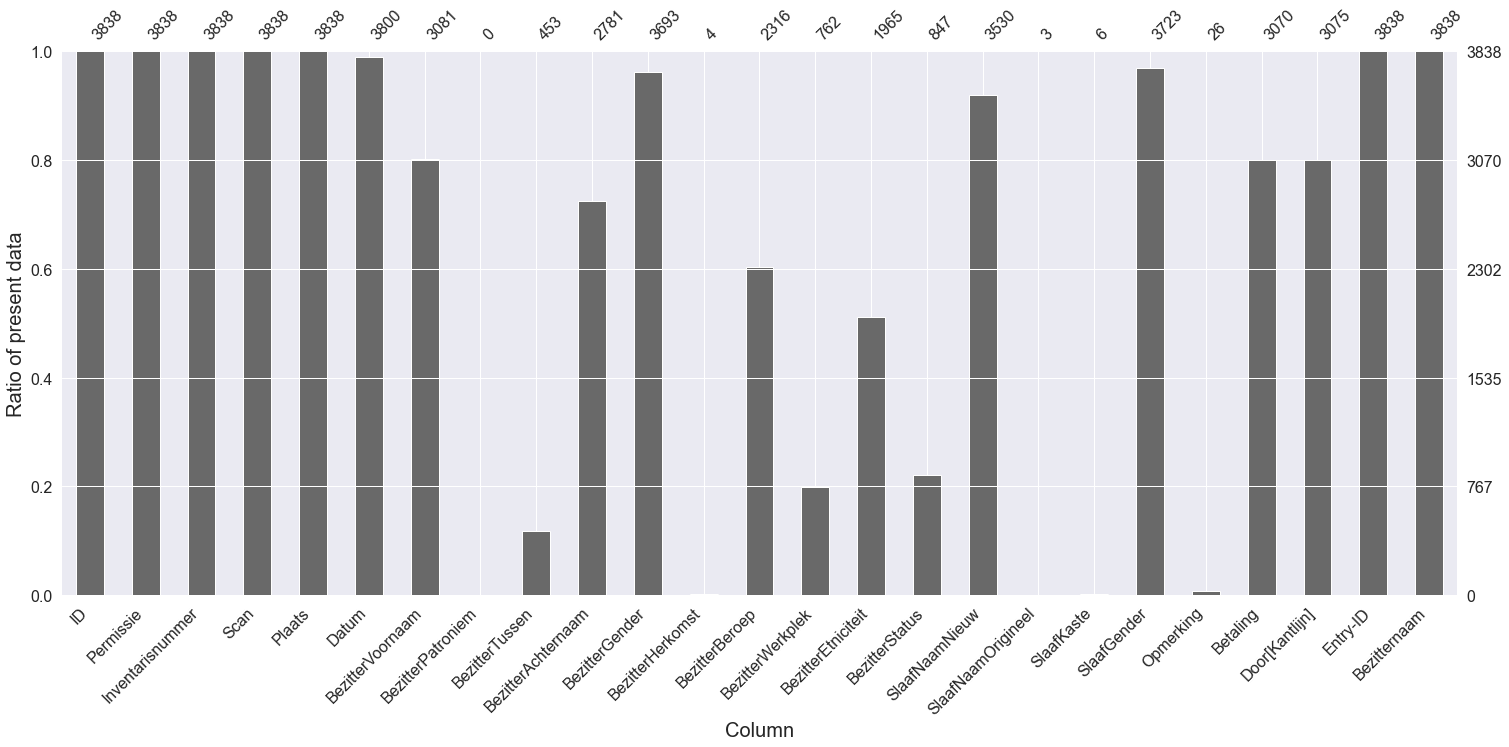

In [14]:
fontsize = 20
ax = msno.bar(permissions)
ax.set_xlabel('Column', fontsize=fontsize)
ax.set_ylabel('Ratio of present data', fontsize=fontsize)

plt.savefig(figure_folder + 'missing_permission.png', bbox_inches='tight')

# Distances EDA

In [15]:
distances = pd.read_csv(dist_folder + "/distances_0.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
for i in range(1, 99):
    df2 = pd.read_csv(f"{dist_folder}/distances_{i}.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
    distances = pd.concat([distances, df2])
distances.reset_index(inplace=True)

In [16]:
distances["Match"] = 0
for i, match in matches.iterrows():
    if match["transaction_indx"] != "None":
        indx = distances.query(f"permission_indx == {match['permission_indx']} & transaction_indx == {match['transaction_indx']}").index
        distances.loc[indx, "Match"] = 1

In [17]:
only_matches = distances[distances["Match"] == 1]
no_matches = distances[distances["Match"] == 0]

In [18]:
set(list(distances["Match"]))

{0, 1}

In [19]:
distances

,index,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterTussen,BezitterAchternaam,BezitterBeroep,BezitterStatus,BezitterEtniciteit,Match
0,0,0,0,True,0.000000,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
1,1,0,1,True,0.250000,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
2,2,0,2,False,0.166626,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
3,3,0,3,True,0.111084,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
4,4,0,4,True,0.142822,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27314395,273139,3888,7192,True,0.142822,True,0.166626,0.0,0.166626,0.0,0.0,1.0,0
27314396,273140,3888,7193,False,0.142822,True,0.166626,0.0,0.166626,0.0,0.0,1.0,0
27314397,273141,3888,7194,False,0.000000,True,0.277832,0.0,0.166626,0.0,0.0,1.0,0
27314398,273142,3888,7195,False,0.111084,True,0.277832,0.0,0.166626,0.0,0.0,1.0,0


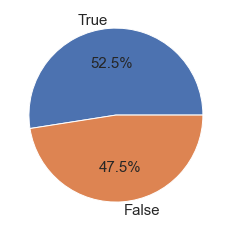

In [20]:
def boolean_pie_chart(ax, col, col_name=None, y_label=None):
    true = (col == 1).sum()
    false = (col == 0).sum()
    ax.pie([true, false], labels=["True", "False"], autopct='%1.1f%%')
    
boolean_pie_chart(plt, distances["SlaafGender"])

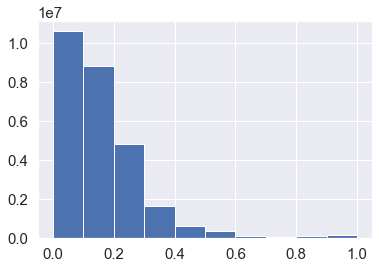

In [21]:
def hist_plot(ax, col, col_name=None, y_label=False):
    ax.hist(col)
    if col_name:
        ax.set_xlabel(col_name)
    if y_label:
        ax.set_ylabel("Number of occurences")

hist_plot(plt, distances["SlaafNaamNieuw"])

In [22]:
def plot_datasets(dfs, plt_func, col_name=""):
    fig, axs = plt.subplots(1, len(dfs), figsize=(10,3))
    for j, df in enumerate(dfs):
        if j == 0:
            y_label = 1
        else:
            y_label = 0
        plt_func[0](axs[j], df[0][plt_func[1]], col_name=col_name, y_label=y_label)
        axs[j].set_title(df[1])
    plt.tight_layout()
    plt.savefig(figure_folder + f"distribution_{col_name}.png")
    plt.show()

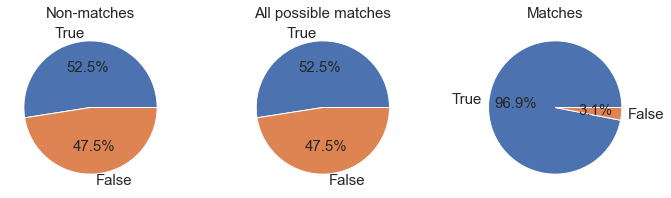

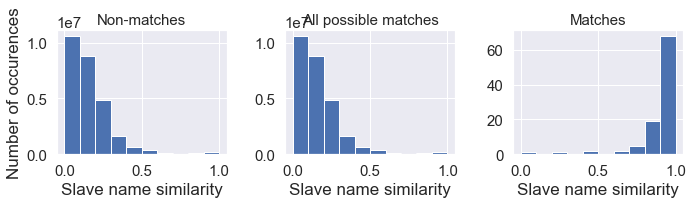

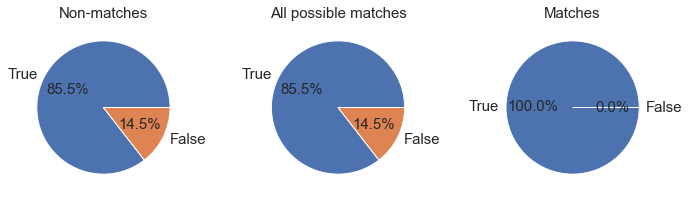

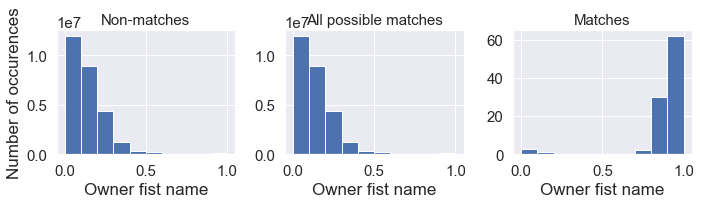

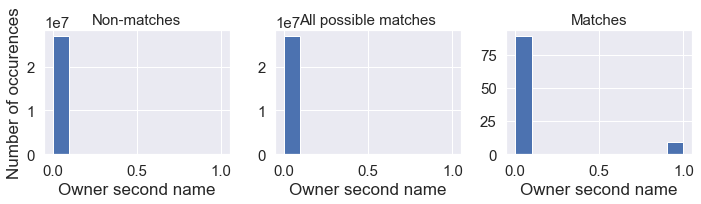

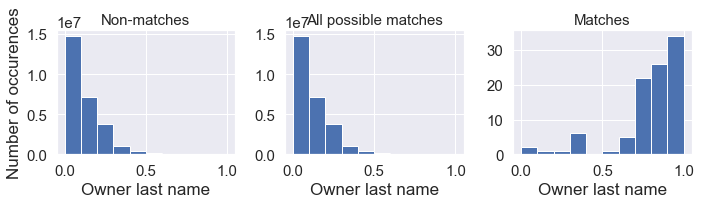

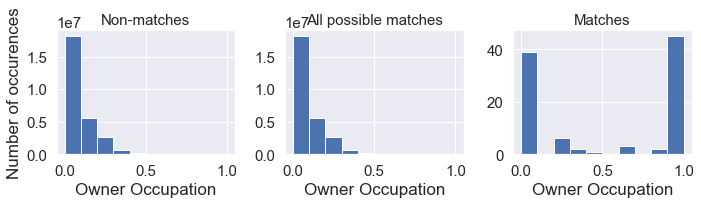

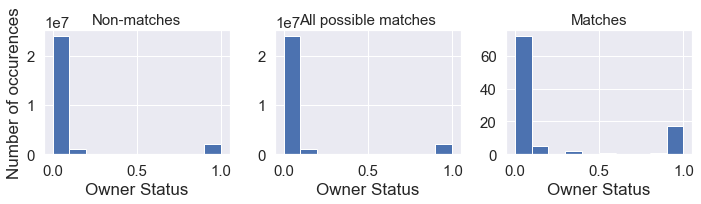

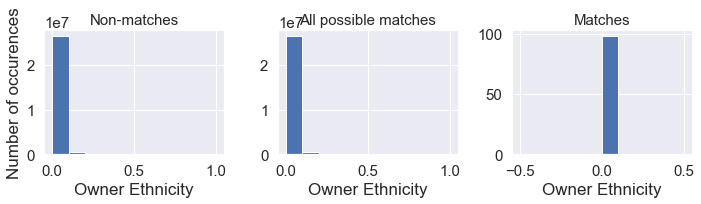

In [23]:
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (boolean_pie_chart, "SlaafGender"), col_name="Slave Gender")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "SlaafNaamNieuw"), col_name="Slave name similarity")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (boolean_pie_chart, "BezitterGender"), col_name="Owner Gender")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterVoornaam"), col_name="Owner fist name")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterTussen"), col_name="Owner second name")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterAchternaam"), col_name="Owner last name")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterBeroep"), col_name="Owner Occupation")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterStatus"), col_name="Owner Status")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterEtniciteit"), col_name="Owner Ethnicity")

In [24]:
only_matches

,index,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterTussen,BezitterAchternaam,BezitterBeroep,BezitterStatus,BezitterEtniciteit,Match
226923,226923,32,4097,True,0.856934,True,0.846191,0.0,1.000000,0.919922,0.0,0.0,1
234255,234255,33,4242,True,1.000000,True,0.916504,0.0,1.000000,0.919922,0.0,0.0,1
241429,241429,34,4228,True,0.428467,True,0.846191,0.0,1.000000,0.360107,0.0,0.0,1
270173,270173,38,4220,True,1.000000,True,0.888672,0.0,0.714355,1.000000,0.0,0.0,1
284531,4199,40,4202,True,1.000000,True,1.000000,0.0,0.856934,1.000000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800735,156419,529,5475,True,0.777832,True,0.875000,0.0,0.625000,0.000000,1.0,0.0,1
3801093,156777,529,5833,True,0.888672,True,0.875000,0.0,0.625000,0.000000,1.0,0.0,1
3801201,156885,529,5941,True,0.888672,True,1.000000,0.0,0.625000,0.000000,1.0,0.0,1
3806706,162390,530,4257,True,1.000000,True,0.909180,0.0,1.000000,0.000000,0.0,0.0,1


In [25]:
no_matches

,index,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterTussen,BezitterAchternaam,BezitterBeroep,BezitterStatus,BezitterEtniciteit,Match
0,0,0,0,True,0.000000,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
1,1,0,1,True,0.250000,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
2,2,0,2,False,0.166626,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
3,3,0,3,True,0.111084,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
4,4,0,4,True,0.142822,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27314395,273139,3888,7192,True,0.142822,True,0.166626,0.0,0.166626,0.0,0.0,1.0,0
27314396,273140,3888,7193,False,0.142822,True,0.166626,0.0,0.166626,0.0,0.0,1.0,0
27314397,273141,3888,7194,False,0.000000,True,0.277832,0.0,0.166626,0.0,0.0,1.0,0
27314398,273142,3888,7195,False,0.111084,True,0.277832,0.0,0.166626,0.0,0.0,1.0,0


In [26]:
only_matches.astype(float).mean()

index                 131922.897959
permission_indx          263.540816
transaction_indx        4008.642857
SlaafGender                0.969388
SlaafNaamNieuw             0.924765
BezitterGender             1.000000
BezitterVoornaam           0.913898
BezitterTussen             0.091837
BezitterAchternaam         0.802929
BezitterBeroep             0.515508
BezitterStatus             0.205452
BezitterEtniciteit         0.000000
Match                      1.000000
dtype: float64

In [28]:
no_matches.astype(float).mean()

index                 137973.181708
permission_indx         1925.215962
transaction_indx        3595.913516
SlaafGender                0.524722
SlaafNaamNieuw             0.135361
BezitterGender             0.855278
BezitterVoornaam           0.120931
BezitterTussen             0.008434
BezitterAchternaam         0.094007
BezitterBeroep             0.069481
BezitterStatus             0.085201
BezitterEtniciteit         0.007328
Match                      0.000000
dtype: float64

In [29]:
mean_only_matches = only_matches.astype(float).mean()[3:-1]
no_only_matches = no_matches.astype(float).mean()[3:-1]

In [30]:
pd.concat([mean_only_matches, no_only_matches], axis=1)

,0,1
SlaafGender,0.969388,0.524722
SlaafNaamNieuw,0.924765,0.135361
BezitterGender,1.000000,0.855278
BezitterVoornaam,0.913898,0.120931
BezitterTussen,0.091837,0.008434
BezitterAchternaam,0.802929,0.094007
BezitterBeroep,0.515508,0.069481
BezitterStatus,0.205452,0.085201
BezitterEtniciteit,0.000000,0.007328


In [31]:
no_only_matches.index

Index(['SlaafGender', 'SlaafNaamNieuw', 'BezitterGender', 'BezitterVoornaam',
       'BezitterTussen', 'BezitterAchternaam', 'BezitterBeroep',
       'BezitterStatus', 'BezitterEtniciteit'],
      dtype='object')

In [34]:
from scipy.stats import ttest_ind

ttest_ind(only_matches['SlaafGender'], no_matches['SlaafGender'], equal_var=False)

Ttest_indResult(statistic=25.422403983961914, pvalue=1.1032485304796256e-44)

In [67]:
tv = []
pv = []
for col in only_matches.columns[3:-1]:
    res = ttest_ind(only_matches[col], no_matches[col], equal_var=False)
    tv.append(res.statistic)
    pv.append(res.pvalue)

In [68]:
only_matches['SlaafGender'].mean() -  no_matches['SlaafGender'].mean()

0.4446656516413703

In [73]:
index = ["Slave Gender Similarity", "Slave Name Similarity", "Owner Gender Similarity", "Owner First Name Similarity", "Owner Second Name Similarity", "Owner Last Name Similarity", "Owner Occupation Similarity", "Owner Status Similarity", "Owner Ethnicity Similarity"]
mean = pd.concat([mean_only_matches, no_only_matches, (mean_only_matches - no_only_matches).abs()], axis=1)
mean.index = index
mean.columns = ["Mean value of matches", "Mean value of non-Matches", "Difference of mean"]
# mean["T-value"] = tv
# mean["P-value"] = pv
print(mean.round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Mean value of matches &  Mean value of non-Matches &  Difference of mean \\
\midrule
Slave Gender Similarity      &                   0.97 &                       0.52 &                0.44 \\
Slave Name Similarity        &                   0.92 &                       0.14 &                0.79 \\
Owner Gender Similarity      &                   1.00 &                       0.86 &                0.14 \\
Owner First Name Similarity  &                   0.91 &                       0.12 &                0.79 \\
Owner Second Name Similarity &                   0.09 &                       0.01 &                0.08 \\
Owner Last Name Similarity   &                   0.80 &                       0.09 &                0.71 \\
Owner Occupation Similarity  &                   0.52 &                       0.07 &                0.45 \\
Owner Status Similarity      &                   0.21 &                       0.09 &                0.12 \\
Owner Ethnicit